# Mutliple multiplications - inspecting individual trained examples

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path
import pickle

from physics_mi.utils import set_all_seeds

RESULTS = Path("results")

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

3576852311


## Model

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Results

In [4]:
fps = list(RESULTS.glob("*.pkl"))

rows = []
for fp in tqdm(fps):
    with open(fp, "rb") as f:
        data = pickle.load(f)
    rows.append(data)

df = pd.DataFrame(rows)

df["valid_loss"] = df["valid_loss"].map(float)

  0%|          | 0/142 [00:00<?, ?it/s]

In [5]:
df.head()

,valid_loss,outputs,model,seed
0,0.000400,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.1858), ...",1080586112
1,0.000664,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(0.0037), t...",825201060
2,0.000276,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.4611), ...",500382378
3,0.000242,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.2236), ...",340316710
4,0.000163,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(0.2780), t...",337361766


## Choose example

In [6]:
row = df.sample().iloc[0]
row

valid_loss                                             0.000241
outputs       {'layers.0.linear.weight': [[tensor(0.), tenso...
model         {'layers.0.linear.weight': [[tensor(0.3726), t...
seed                                                  648490671
Name: 110, dtype: object

## Introspection

In [7]:
N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
pairs = pairs.repeat(2, axis=0).reshape(-1, 4)


def plot_node_activity(acts, eps=0.05):
    fig, axes = plt.subplots(4, 4, figsize=(12, 10))  # Increase the width to make space for the colorbar
    axes = axes.flatten()

    for i in range(acts.shape[1]):
        col = acts[:, i]
        activated_mask = np.abs(acts[:, i]) > eps  # really trying to focus on the activated areas
        activated_mask = torch.ones(col.shape, dtype=bool)
        sc = axes[i].scatter(
            pairs[activated_mask, 0],
            pairs[activated_mask, 1],
            c=col[activated_mask],
            cmap="bwr",
            s=50,
            norm=plt.Normalize(vmin=-1, vmax=1),
        )

        axes[i].set_title(f"Node {i+1}")
        axes[i].set_xlabel("x1")
        axes[i].set_ylabel("x2")
        axes[i].set_aspect("equal")
        axes[i].set_xlim(-0.05, 1.05)
        axes[i].set_ylim(-0.05, 1.05)

    # Position the colorbar on the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cbar_ax)

    fig.suptitle("Activity of each node")
    fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots

In [8]:
acts = row["outputs"]["layers.0.act"]
lws = row["model"]["layers.1.linear.weight"]
ncs = acts[..., None] * lws.T
ncs = ncs.numpy()
ncs.shape

(25, 16, 2)

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_68969/653771749.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


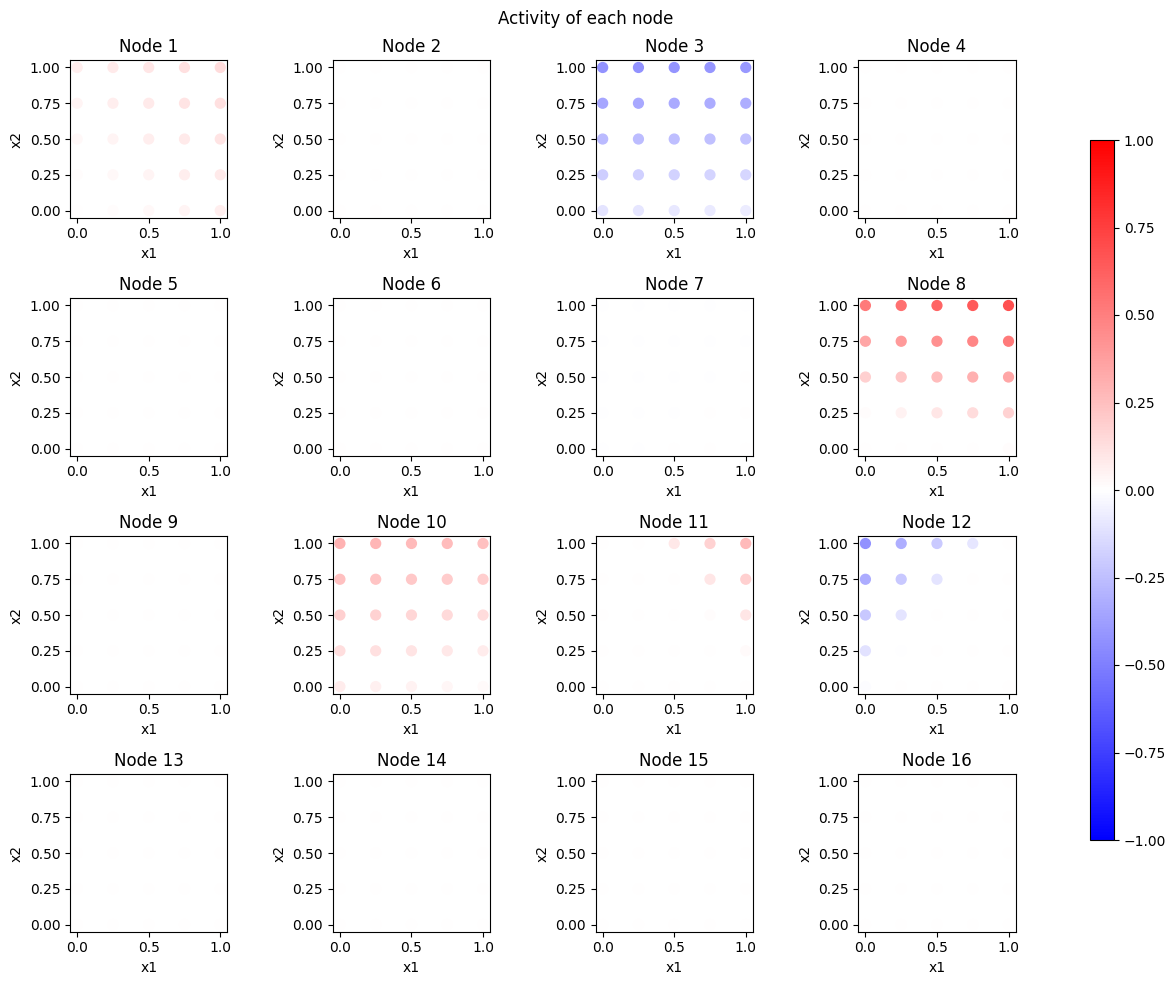

In [9]:
plot_node_activity(ncs[:, :, 0])

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_68969/653771749.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


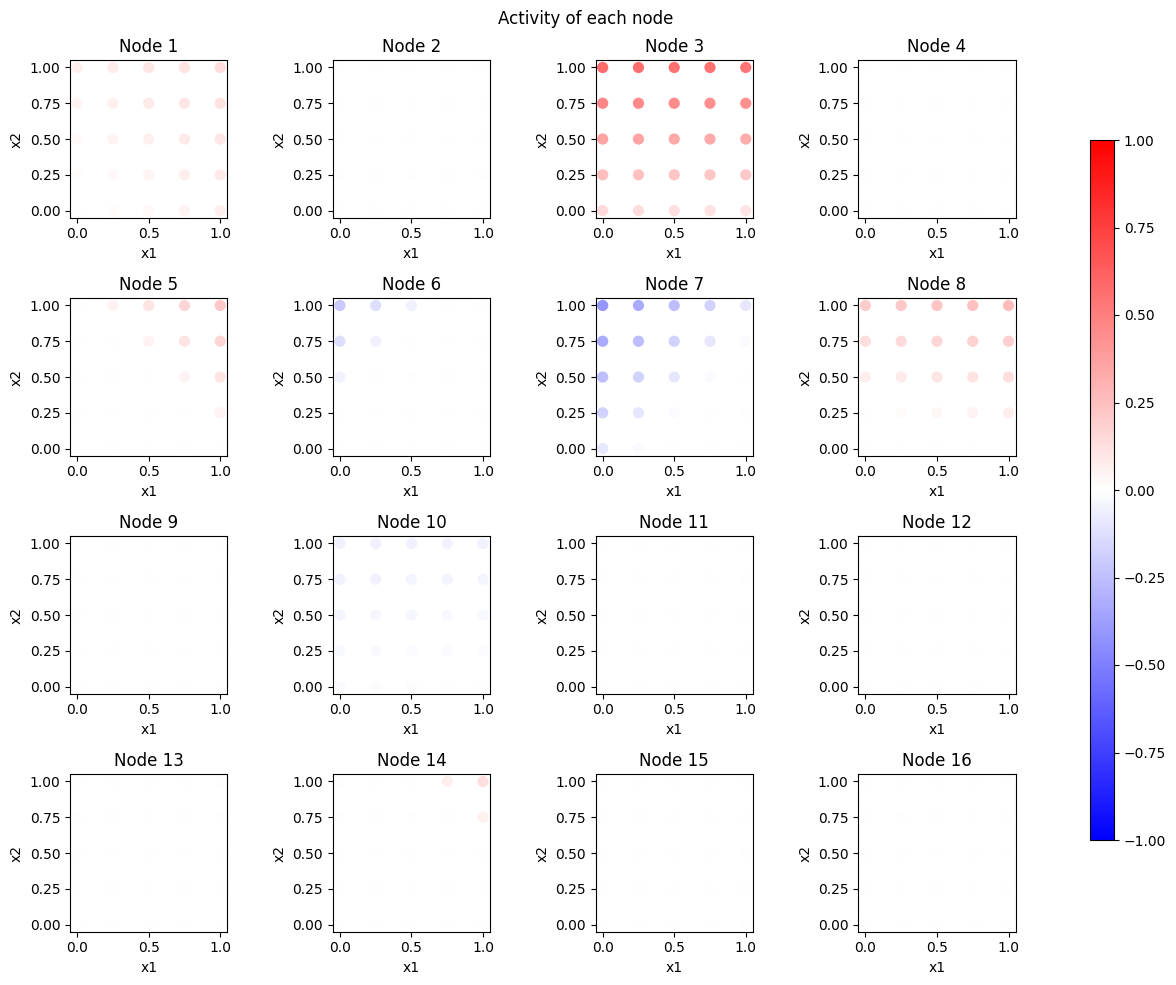

In [10]:
plot_node_activity(ncs[:, :, 1])

In [11]:
def remove_dead_neurons(ncs):
    return ncs[:, ~(ncs == 0).all(0).all(1)]


def get_hos(ncss):
    angles = np.arctan2(ncss[..., 1], ncss[..., 0])
    hos = np.abs(
        (np.mod(angles, np.pi / 2) - np.pi / 4) / (np.pi / 4)
    )  # I'm sure there's a neater way of doing this...
    return hos


ancs = remove_dead_neurons(ncs)

In [12]:
hos = get_hos(ncs).mean(0)
hos.reshape(4, 4)

array([[0.06479414, 0.9999998 , 0.18901779, 0.9999998 ],
       [0.9839937 , 0.99635893, 0.99496126, 0.61424166],
       [1.        , 0.73701936, 0.99979407, 0.99753106],
       [0.9999998 , 0.9990289 , 1.        , 1.        ]], dtype=float32)

In [13]:
eps = 1e-5
mncs = np.abs(ncs.mean(0)).mean(-1)
mncs.shape

(16,)

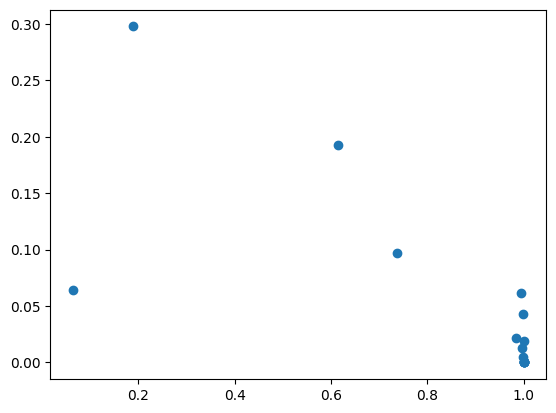

In [14]:
plt.scatter(hos, mncs)

In [15]:
ortho_mask = hos > 0.95
mncs[ortho_mask].sum(), mncs[~ortho_mask].sum()

(0.1625966, 0.65083337)

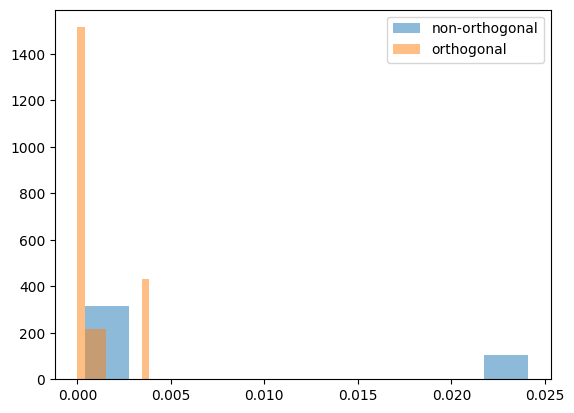

In [16]:
fig, ax = plt.subplots()

ax.hist(np.var(ncs.mean(-1)[:, ~ortho_mask], 0), alpha=0.5, label="non-orthogonal", density=True)
ax.hist(np.var(ncs.mean(-1)[:, ortho_mask], 0), alpha=0.5, label="orthogonal", density=True)

ax.legend()

In [17]:
model = Net()
model.load_state_dict(row["model"])
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

I've made this interactive plot to see how each of the inputs modifies the intermediate activations.

In [18]:
from physics_mi.analysis import capture_intermediate_outputs
import plotly.graph_objs as go
from ipywidgets import VBox, FloatSlider, HBox


def plot_intermediate_outputs_interactive(model):
    # Define sliders
    slider1 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 1")
    slider2 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 2")
    slider3 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 3")
    slider4 = FloatSlider(min=0, max=1, step=0.01, value=0.5, description="Input 4")

    # Process data function that returns a dictionary
    def process_data(s1, s2, s3, s4):
        input = torch.tensor([[s1, s2, s3, s4]])
        # Replace this with your own computation
        ios = capture_intermediate_outputs(model, input)
        ios["neuron contribution 1"] = ios["layers.0.act"] * ios["layers.1.linear.weight"][:, 0]
        ios["neuron contribution 2"] = ios["layers.0.act"] * ios["layers.1.linear.weight"][:, 1]
        ios.pop("layers.0.linear.weight")
        ios.pop("layers.0.linear.bias")
        ios.pop("layers.1.linear.bias")
        return ios

    # Create a dictionary of figures, one for each entry in the processed data
    figures = {}

    for chart_name, data in process_data(slider1.value, slider2.value, slider3.value, slider4.value).items():
        data = data[0].numpy()
        fig = go.FigureWidget(data=[go.Bar(x=[f"{i+1}" for i in range(len(data))], y=data)])
        fig.update_layout(title=f"{chart_name}", xaxis_title="Neurons", yaxis_title="Value", yaxis=dict(range=[-1, 1]))
        figures[chart_name] = fig

    # Function to update all the figures
    def update_graph(change):
        processed_data = process_data(slider1.value, slider2.value, slider3.value, slider4.value)
        for chart_name, data in processed_data.items():
            data = data[0].numpy()
            figures[chart_name].data[0].y = data

    # Observe changes to the slider values
    slider1.observe(update_graph, names="value")
    slider2.observe(update_graph, names="value")
    slider3.observe(update_graph, names="value")
    slider4.observe(update_graph, names="value")

    # Display sliders and the figures
    display(VBox([slider1, slider2, slider3, slider4] + [figures[name] for name in figures]))

In [19]:
plot_intermediate_outputs_interactive(model)

So we can see these interfering neurons (i.e. neurons that are shared between each indpendent task) quite clearly, the interesting part is that there is barely any bleed in between the two tasks as a result. I'd imagine there's some balancing at play here, and I think I have some ideas to investigate it. 

## Control

I'm going to vary one input and observe how the activations change for the alternative output. We know that their sum will remain roughly zero, but _how_? I'm kind of thinking about transformations on a plane vs. perpendicular to the plane sort of thing 🤔

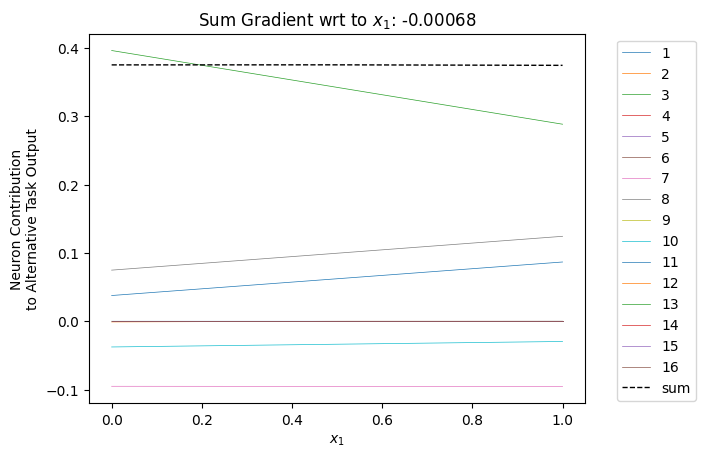

In [20]:
x1 = torch.linspace(0, 1, 20)
x2 = torch.full_like(x1, 0.5)
x3 = torch.full_like(x1, 0.5)
x4 = torch.full_like(x1, 0.5)

inputs = torch.stack([x1, x2, x3, x4], 1)

outputs = [capture_intermediate_outputs(model, input) for input in inputs]
outputs = [o["layers.0.act"] for o in outputs]
outputs = [
    outputs * row["model"]["layers.1.linear.weight"][1] for outputs in outputs
]  # multiply by for alternative task output
outputs = torch.stack(outputs, 1)

fig, ax = plt.subplots()

for i, output in enumerate(outputs):
    ax.plot(x1, output, label=i + 1, lw=0.5)

ax.plot(x1, outputs.sum(0), label="sum", lw=1, c="k", ls="--")
# linear regression on sum to find the gradient
m, c = np.polyfit(x1, outputs.sum(0), 1)

ax.set_xlabel("$x_1$")
ax.set_ylabel("Neuron Contribution\nto Alternative Task Output")

ax.set_title("Sum Gradient wrt to $x_1$: {:.5f}".format(m))

_ = ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

Ok so _this_ was what was making life so difficult. My original hypothesis that the neurons would separate nicely task-wise is obviously incorrect. Instead, we can see that it doesn't _matter_ that the neurons fire for both tasks since the final linear layer learns a weighting to balance them out.

I still would like to understand this geometrically because I'm sure it's fairly straightfoward 🤔

My interest now is in whether these same neurons vary destructively in the other task too.

These are the neurons which vary the most for $x_1$ (in descending order):

In [21]:
grads = []
for output in outputs:
    m, c = np.polyfit(x1, output, 1)
    grads.append(m)
grads1 = np.array(grads)
np.arange(1, len(output) + 1)[np.argsort(np.abs(grads1))[::-1]]

array([ 3,  8,  1, 10, 12,  7, 11, 16, 15, 14, 13,  9,  6,  5,  4,  2])

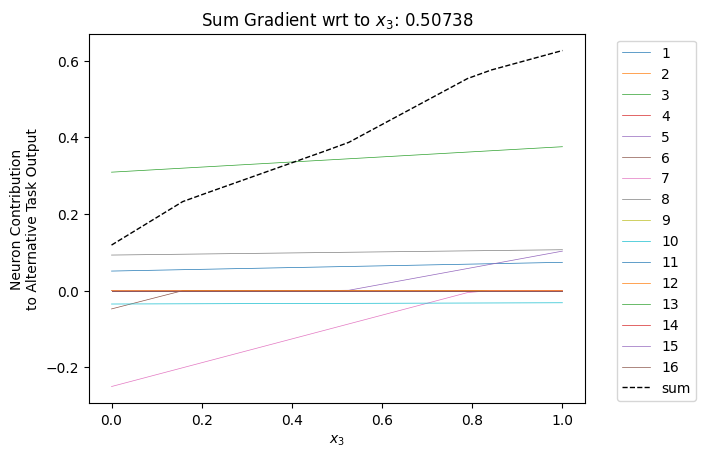

In [22]:
x3 = torch.linspace(0, 1, 20)
x2 = torch.full_like(x3, 0.5)
x1 = torch.full_like(x3, 0.5)
x4 = torch.full_like(x3, 0.5)

inputs = torch.stack([x1, x2, x3, x4], 1)

outputs = [capture_intermediate_outputs(model, input) for input in inputs]
outputs = [o["layers.0.act"] for o in outputs]
outputs = [
    outputs * row["model"]["layers.1.linear.weight"][1] for outputs in outputs
]  # multiply by for alternative task output
outputs = torch.stack(outputs, 1)

fig, ax = plt.subplots()

for i, output in enumerate(outputs):
    ax.plot(x3, output, label=i + 1, lw=0.5)

ax.plot(x3, outputs.sum(0), label="sum", lw=1, c="k", ls="--")
# linear regression on sum to find the gradient
m, c = np.polyfit(x3, outputs.sum(0), 1)

ax.set_xlabel("$x_3$")
ax.set_ylabel("Neuron Contribution\nto Alternative Task Output")

ax.set_title("Sum Gradient wrt to $x_3$: {:.5f}".format(m))

_ = ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [23]:
grads = []
for output in outputs:
    m, c = np.polyfit(x3, output, 1)
    grads.append(m)
grads2 = np.array(grads)
np.arange(1, len(output) + 1)[np.argsort(np.abs(grads))[::-1]]

array([ 7,  5,  3,  6,  1,  8, 10, 12, 16, 15, 14, 13, 11,  9,  4,  2])

My intuition is that when varying inputs to the first task, we are moving around on a plane perpendicular to the direction vector defined by the linear projection onto the second task's output and vice versa. This means there exist two hyperplanes that we might be interested in for a 2-task system. 

Intuitively, I'd imagine these two hyperplanes must be perpendicular to each other in order for the outputs to be independent since one hyperplane is that which produces the desired output in $y_1$ without producing a variation in $y_2$ and vice versa.

In [24]:
torch.dot(lws[0], lws[1]) / (torch.norm(lws[0]) * torch.norm(lws[1]))

tensor(-0.0464)

So _really_ all this time, I simply needed to dot the two linear projection vectors together to determine whether the two tasks were independent 🙃 Really feel like I'm rediscovering linear algebra for myself here... but it feels good.

Supposedly, if we were to rotate the whole system into the natural basis of the neurons, then the whole system would behave identically but be more interpretable. I think this would only be true of the output layer though...

### Verify orthogonality of final linear projections

Because why not.

In [25]:
sims = []
for i, row in df.iterrows():
    lws = row["model"]["layers.1.linear.weight"]
    sim = torch.dot(lws[0], lws[1]) / (torch.norm(lws[0]) * torch.norm(lws[1]))
    sims.append(float(sim))
df["sim"] = sims

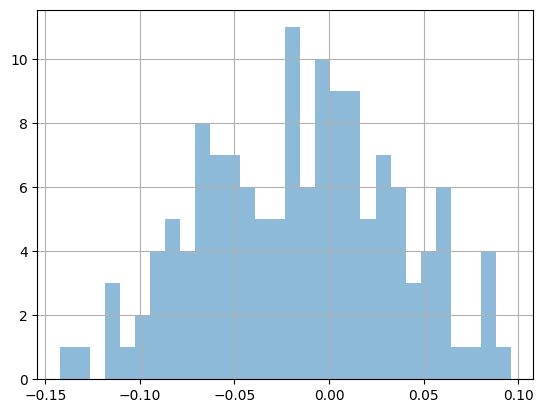

In [26]:
_ = df["sim"].hist(alpha=0.5, label="sim", bins=30)

I'd hypothesise that the networks with less orthogonal tasks have a lower loss. Let's see:

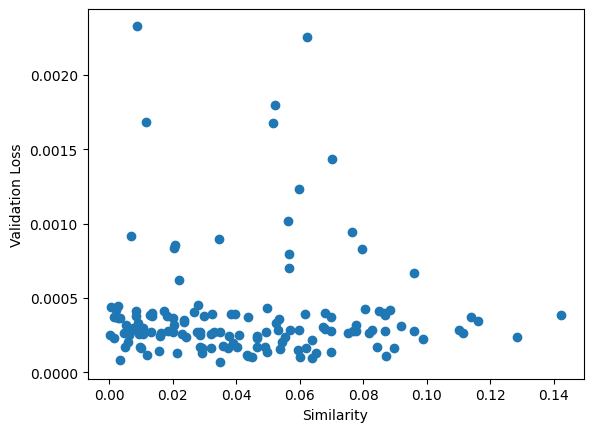

In [27]:
fig, ax = plt.subplots()

ax.scatter(df["sim"].abs(), df["valid_loss"])
ax.set_xlabel("Similarity")
_ = ax.set_ylabel("Validation Loss")

Not really much we can see here. I'm interested in how the networks with less orthogonal tasks can still produce low losses. 

In [31]:
SD = df.loc[(df["sim"].abs() > 0.14) & (df["valid_loss"] < 5e-3), "model"].iloc[0]
model = Net()
model.load_state_dict(SD)

<All keys matched successfully>

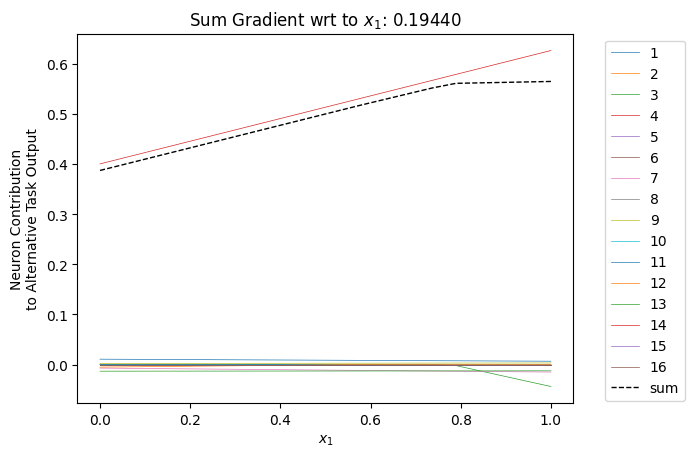

In [32]:
x1 = torch.linspace(0, 1, 20)
x2 = torch.full_like(x1, 0.5)
x3 = torch.full_like(x1, 0.5)
x4 = torch.full_like(x1, 0.5)

inputs = torch.stack([x1, x2, x3, x4], 1)

outputs = [capture_intermediate_outputs(model, input) for input in inputs]
outputs = [o["layers.0.act"] for o in outputs]
outputs = [
    outputs * row["model"]["layers.1.linear.weight"][1] for outputs in outputs
]  # multiply by for alternative task output
outputs = torch.stack(outputs, 1)

fig, ax = plt.subplots()

for i, output in enumerate(outputs):
    ax.plot(x1, output, label=i + 1, lw=0.5)

ax.plot(x1, outputs.sum(0), label="sum", lw=1, c="k", ls="--")
# linear regression on sum to find the gradient
m, c = np.polyfit(x1, outputs.sum(0), 1)

ax.set_xlabel("$x_1$")
ax.set_ylabel("Neuron Contribution\nto Alternative Task Output")

ax.set_title("Sum Gradient wrt to $x_1$: {:.5f}".format(m))

_ = ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

I suppose the loss just doesn't penalise this so much - suppose it could be to do with MSE.

### What does this mean for interpretability?

In starting this multi-task experiment, I was interested in whether we could easily locate and classify multiple operations happening in parallel.

In this case, I suppose we have in some sense "located" the separate operations, but that was easy in the single-layer case because we could just use the final linear layer.

Idea: varying a subset of the inputs and then finding the vector perpendicular to the traversed hyperplane. See whether this vector exists in the weight matrix of the following layer. If it _does_ then it might suggest that this particular operation represents an independent operation? This isn't a very sophisticated idea, because it's equivalent to looking to see whether a particular pre-activation neuron is altered by changing some inputs.

I suppose an issue arises in that the following weight matrix won't even necessarily try to transform the input into the natural basis (like we see with the final linear layer) because it isn't restricted to.

Hmm lots of thought.